# Cloud Masking: Dealing with Atmospheric Interference

So far, we've been careful to select images with low cloud cover. But what happens when clouds *are* present?

**The problem:**
- Clouds reflect sunlight before it reaches the Earth's surface
- The satellite measures the cloud's reflectance, not the ground's
- This corrupts our NDVI calculations — a forest under a cloud might show NDVI ~0.1 instead of ~0.7

**The solution:**
- Sentinel-2 provides a **Scene Classification Layer (SCL)** that labels each pixel
- We can use this to **mask out** clouds and compute NDVI only for valid pixels

In this notebook we'll:
1. Load an image WITH clouds (intentionally)
2. See how clouds affect NDVI
3. Understand the Scene Classification Layer
4. Apply cloud masking
5. Compare before/after results

---
## 1. Setup

In [1]:
from pystac_client import Client
import planetary_computer as pc
from odc.stac import stac_load

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import warnings
warnings.filterwarnings('ignore')

# Connect to Planetary Computer
catalog = Client.open("https://planetarycomputer.microsoft.com/api/stac/v1")
print("Connected to Planetary Computer")

/Users/hds-altec009/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


Connected to Planetary Computer


---
## 2. Helper Functions

In [2]:
def normalize(img, pmin=2, pmax=98):
    """Normalize image to 0-1 range using percentiles."""
    lo, hi = np.nanpercentile(img, [pmin, pmax])
    return np.clip((img - lo) / (hi - lo + 1e-6), 0, 1)

def compute_ndvi(nir, red):
    """Compute NDVI from NIR and Red bands."""
    return (nir - red) / (nir + red + 1e-6)

print("Helper functions defined.")

Helper functions defined.


---
## 3. Find a Cloudy Image (Intentionally!)

For this lesson, we *want* clouds. Let's search for an image with moderate cloud cover (30-40%) so we can see both cloudy and clear areas.

In [230]:
# Different location because the previous location that was in the other notebooks, doesn't provide a good example case for this experiment. 
bbox = [-0.25, 51.45, 0.05, 51.60] #London Area

# Search for CLOUDY images (30-60% cloud cover)
search = catalog.search(
    collections=["sentinel-2-l2a"],
    bbox=bbox,
    datetime="2024-01-01/2024-12-31",
    query={"eo:cloud_cover": {"gte": 30, "lte": 35}},  # 30-35% clouds
)

items = list(search.items())
print(f"Found {len(items)} images with 30-60% cloud cover")

# Pick one in the middle of the range
items_sorted = sorted(items, key=lambda x: abs(x.properties.get('eo:cloud_cover', 0) - 45))
cloudy_item = items_sorted[0]

print(f"\nSelected image:")
print(f"  Date: {cloudy_item.datetime}")
print(f"  Cloud cover: {cloudy_item.properties.get('eo:cloud_cover', 0):.1f}%")

Found 11 images with 30-60% cloud cover

Selected image:
  Date: 2024-06-24 11:06:41.024000+00:00
  Cloud cover: 35.6%


---
## 4. Load the Cloudy Image

We'll load the usual bands (RGB + NIR) plus the **SCL (Scene Classification Layer)** band.

In [211]:
# Sign the item
signed_item = pc.sign(cloudy_item)

# Load bands INCLUDING the SCL (Scene Classification Layer)
data = stac_load(
    [signed_item],
    bands=["B02", "B03", "B04", "B08", "SCL"],  # Added SCL!
    bbox=bbox,
    crs="EPSG:4326",
    resolution=0.0001,
    groupby="solar_day",
)

print("Loaded bands:", list(data.data_vars))

Loaded bands: ['B02', 'B03', 'B04', 'B08', 'SCL']


---
## 5. Visualize the Cloudy Image

Let's see what we're dealing with — clouds should be visible as bright white areas.

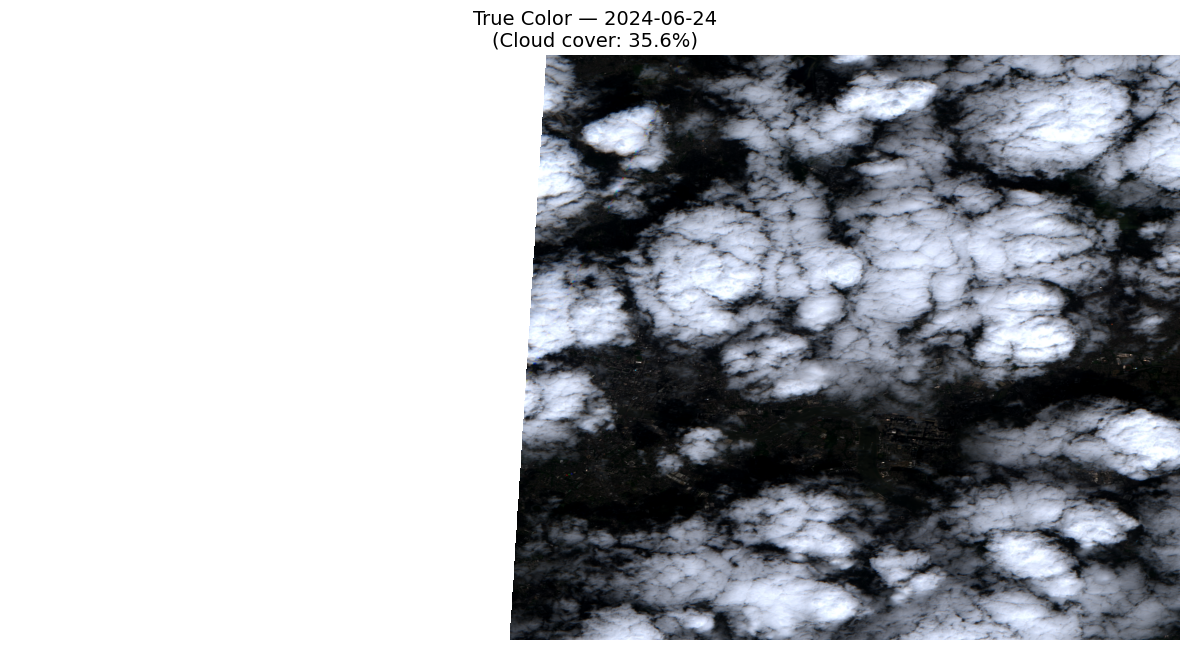

In [212]:
# Create RGB composite
rgb = normalize(np.stack([
    data["B04"].isel(time=0).values,
    data["B03"].isel(time=0).values,
    data["B02"].isel(time=0).values,
], axis=-1))

fig, ax = plt.subplots(figsize=(12, 10))
ax.imshow(rgb)
ax.set_title(f"True Color — {cloudy_item.datetime.strftime('%Y-%m-%d')}\n(Cloud cover: {cloudy_item.properties.get('eo:cloud_cover', 0):.1f}%)", fontsize=14)
ax.axis("off")
plt.tight_layout()
plt.show()

---
## 6. Compute NDVI (Without Cloud Masking)

Let's compute NDVI the "naive" way — ignoring clouds entirely. Notice how cloud-covered areas have corrupted NDVI values.

In [216]:
# Compute NDVI without any masking
nir = data["B08"].isel(time=0).values.astype("float32")
red = data["B04"].isel(time=0).values.astype("float32")

ndvi_raw = compute_ndvi(nir, red)

print(f"Raw NDVI statistics (no cloud masking):")
print(f"  Min: {np.nanmin(ndvi_raw):.2f}")
print(f"  Max: {np.nanmax(ndvi_raw):.2f}")
print(f"  Mean: {np.nanmean(ndvi_raw):.2f}")

Raw NDVI statistics (no cloud masking):
  Min: -0.65
  Max: 0.70
  Mean: 0.04


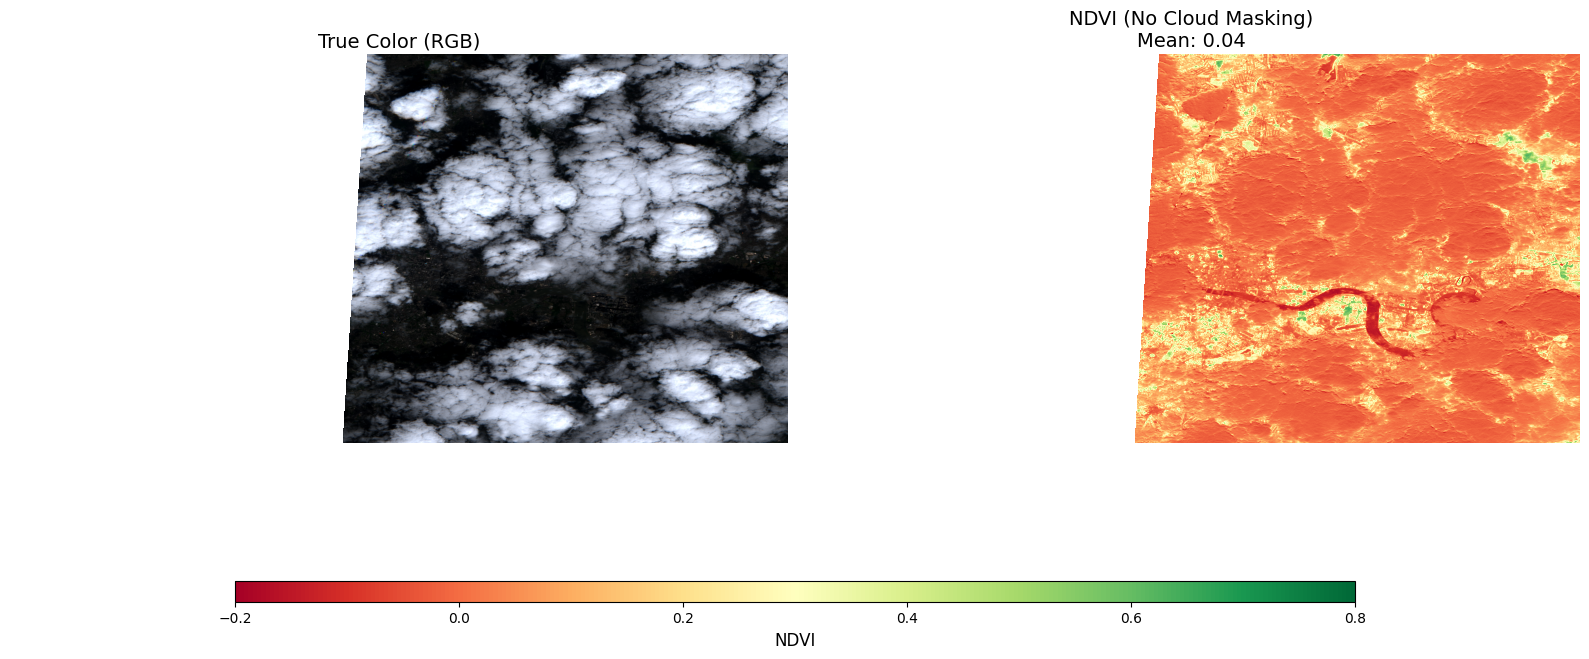

In [217]:
fig, axes = plt.subplots(1, 2, figsize=(16, 7))

# True color
axes[0].imshow(rgb)
axes[0].set_title("True Color (RGB)", fontsize=14)
axes[0].axis("off")

# NDVI without masking
im = axes[1].imshow(ndvi_raw, cmap='RdYlGn', vmin=-0.2, vmax=0.8)
axes[1].set_title(f"NDVI (No Cloud Masking)\nMean: {np.nanmean(ndvi_raw):.2f}", fontsize=14)
axes[1].axis("off")

plt.tight_layout()
cbar_ax = fig.add_axes([0.15, 0.06, 0.7, 0.03])
cbar = fig.colorbar(im, cax=cbar_ax, orientation='horizontal')
cbar.set_label('NDVI', fontsize=12)
plt.subplots_adjust(bottom=0.15)
plt.show()

### The Problem

Notice how the cloudy areas in the true color image show up as **yellow/orange in NDVI** (a mean value at 0.04). 

This is wrong! Those pixels might actually be healthy vegetation underneath the cloud — we just can't see it because the satellite is measuring the cloud's reflectance, not the ground's.

**Why clouds have low NDVI:**
- Clouds reflect Red and NIR fairly equally
- NDVI = (NIR - Red) / (NIR + Red) → when both are similar, NDVI ≈ 0

---
## 7. Understanding the Scene Classification Layer (SCL)

Sentinel-2's SCL band classifies each pixel into categories. Let's see what it looks like.

In [218]:
# Get the SCL band
scl = data["SCL"].isel(time=0).values

print("SCL (Scene Classification Layer) values in this image:")
unique_values = np.unique(scl[~np.isnan(scl)])
print(f"  Unique values: {unique_values}")

SCL (Scene Classification Layer) values in this image:
  Unique values: [2. 3. 4. 5. 6. 7. 8. 9.]


In [219]:
# SCL classification codes
SCL_CLASSES = {
    0: ("No data", "black"),
    1: ("Saturated/Defective", "red"),
    2: ("Dark Area Pixels", "gray"),
    3: ("Cloud Shadow", "brown"),
    4: ("Vegetation", "green"),
    5: ("Bare Soil", "yellow"),
    6: ("Water", "blue"),
    7: ("Unclassified", "pink"),
    8: ("Cloud (Medium Probability)", "lightgray"),
    9: ("Cloud (High Probability)", "white"),
    10: ("Thin Cirrus", "cyan"),
    11: ("Snow/Ice", "lightblue"),
}

print("SCL Classification Codes:")
print("-" * 40)
for code, (name, color) in SCL_CLASSES.items():
    count = np.sum(scl == code)
    pct = 100 * count / scl.size
    if count > 0:
        print(f"  {code:2d}: {name:30s} ({pct:5.1f}%)")

SCL Classification Codes:
----------------------------------------
   2: Dark Area Pixels               (  0.0%)
   3: Cloud Shadow                   (  5.4%)
   4: Vegetation                     (  0.7%)
   5: Bare Soil                      (  1.6%)
   6: Water                          (  0.7%)
   7: Unclassified                   (  0.6%)
   8: Cloud (Medium Probability)     ( 12.0%)
   9: Cloud (High Probability)       ( 34.8%)


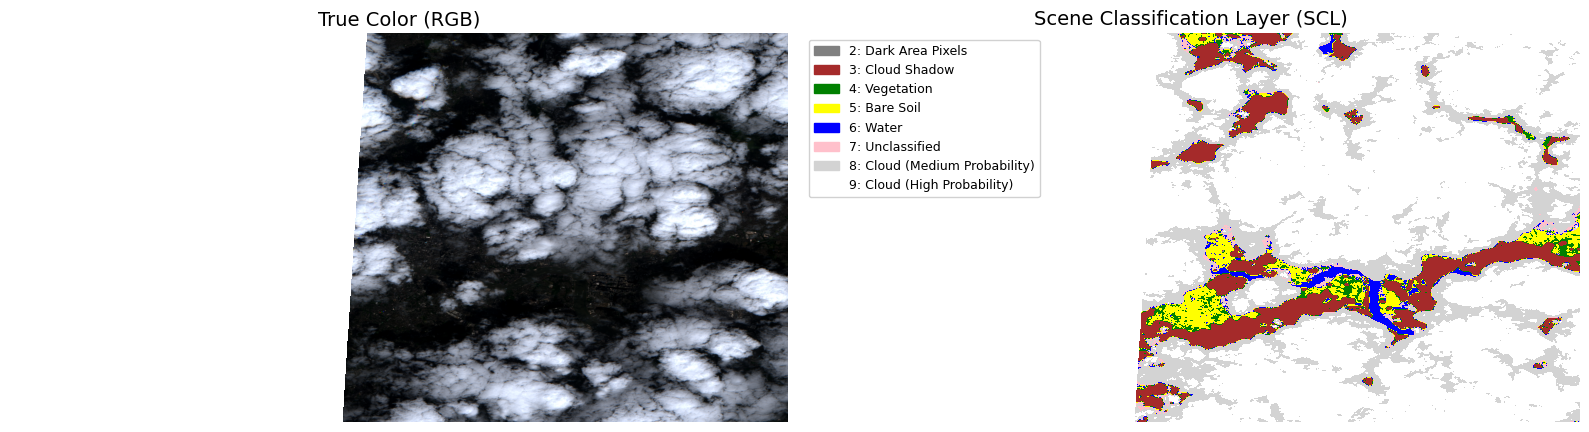

In [220]:
# Create a color map for SCL visualization
from matplotlib.colors import ListedColormap, BoundaryNorm

colors = [SCL_CLASSES[i][1] for i in range(12)]
cmap_scl = ListedColormap(colors)
bounds = np.arange(-0.5, 12.5, 1)
norm = BoundaryNorm(bounds, cmap_scl.N)

fig, axes = plt.subplots(1, 2, figsize=(16, 7))

# True color
axes[0].imshow(rgb)
axes[0].set_title("True Color (RGB)", fontsize=14)
axes[0].axis("off")

# SCL
im = axes[1].imshow(scl, cmap=cmap_scl, norm=norm)
axes[1].set_title("Scene Classification Layer (SCL)", fontsize=14)
axes[1].axis("off")

# Add legend
present_classes = [int(v) for v in unique_values if not np.isnan(v)]
patches = [mpatches.Patch(color=SCL_CLASSES[i][1], label=f"{i}: {SCL_CLASSES[i][0]}") 
           for i in present_classes if i in SCL_CLASSES]
axes[1].legend(handles=patches, loc='upper left', fontsize=9, framealpha=0.9)

plt.tight_layout()
plt.show()

### Understanding the SCL

The SCL tells us what each pixel represents:
- **Green (4):** Vegetation — these are the pixels we trust for NDVI!
- **Yellow (5):** Bare soil — also valid for NDVI (just low values)
- **White/Gray (8, 9):** Clouds — these pixels are INVALID for ground analysis
- **Brown (3):** Cloud shadows — also problematic (darkened by shadow)
- **Blue (6):** Water — valid, but NDVI will be negative

---
## 8. Create a Cloud Mask

Now let's create a mask that excludes problematic pixels.

In [222]:
# Define which SCL values are "good" (not clouds, shadows, etc.)
VALID_SCL_VALUES = [
    4,   # Vegetation
    5,   # Bare soil
    6,   # Water
    # We exclude: 0 (no data), 1 (saturated), 2 (dark), 3 (cloud shadow),
    #             7 (unclassified), 8 (cloud medium), 9 (cloud high),
    #             10 (cirrus), 11 (snow/ice)
]

# Create mask: True = valid pixel, False = invalid (cloud, shadow, etc.)
valid_mask = np.isin(scl, VALID_SCL_VALUES)

# Count statistics
total_pixels = valid_mask.size
valid_pixels = np.sum(valid_mask)
invalid_pixels = total_pixels - valid_pixels

print(f"Mask statistics:")
print(f"  Total pixels:   {total_pixels:,}")
print(f"  Valid pixels:   {valid_pixels:,} ({100*valid_pixels/total_pixels:.1f}%)")
print(f"  Invalid pixels: {invalid_pixels:,} ({100*invalid_pixels/total_pixels:.1f}%)")

Mask statistics:
  Total pixels:   4,500,000
  Valid pixels:   132,487 (2.9%)
  Invalid pixels: 4,367,513 (97.1%)


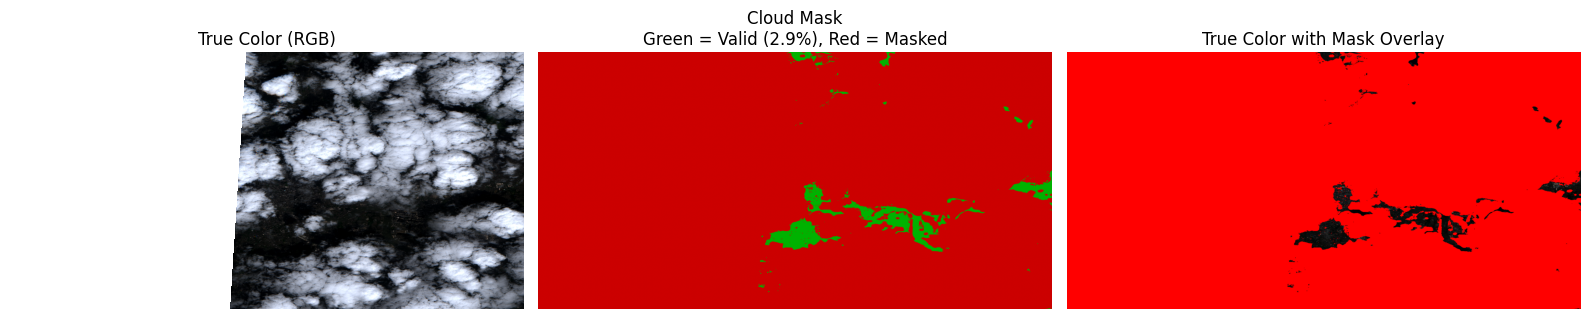

In [223]:
# Visualize the mask
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# True color
axes[0].imshow(rgb)
axes[0].set_title("True Color (RGB)", fontsize=12)
axes[0].axis("off")

# Mask (green = valid, red = masked out)
mask_viz = np.zeros((*valid_mask.shape, 3))
mask_viz[valid_mask] = [0, 0.7, 0]    # Green for valid
mask_viz[~valid_mask] = [0.8, 0, 0]   # Red for invalid
axes[1].imshow(mask_viz)
axes[1].set_title(f"Cloud Mask\nGreen = Valid ({100*valid_pixels/total_pixels:.1f}%), Red = Masked", fontsize=12)
axes[1].axis("off")

# True color with mask overlay
rgb_masked = rgb.copy()
rgb_masked[~valid_mask] = [1, 0, 0]  # Red overlay on masked pixels
axes[2].imshow(rgb_masked)
axes[2].set_title("True Color with Mask Overlay", fontsize=12)
axes[2].axis("off")

plt.tight_layout()
plt.show()

---
## 9. Apply Cloud Mask to NDVI

Now let's compute NDVI again, but this time setting invalid pixels to NaN ("not a number").

In [224]:
# Compute masked NDVI
ndvi_masked = ndvi_raw.copy()
ndvi_masked[~valid_mask] = np.nan  # Set invalid pixels to NaN

print(f"Raw NDVI (no masking):")
print(f"  Mean: {np.nanmean(ndvi_raw):.3f}")
print(f"  Valid pixels: {np.sum(~np.isnan(ndvi_raw)):,}")

print(f"\nMasked NDVI (clouds removed):")
print(f"  Mean: {np.nanmean(ndvi_masked):.3f}")
print(f"  Valid pixels: {np.sum(~np.isnan(ndvi_masked)):,}")

print(f"\nDifference in mean NDVI: {np.nanmean(ndvi_masked) - np.nanmean(ndvi_raw):+.3f}")

Raw NDVI (no masking):
  Mean: 0.042
  Valid pixels: 2,511,094

Masked NDVI (clouds removed):
  Mean: 0.158
  Valid pixels: 132,487

Difference in mean NDVI: +0.116


---
## 10. Before/After Comparison

Let's visualize the difference cloud masking makes.

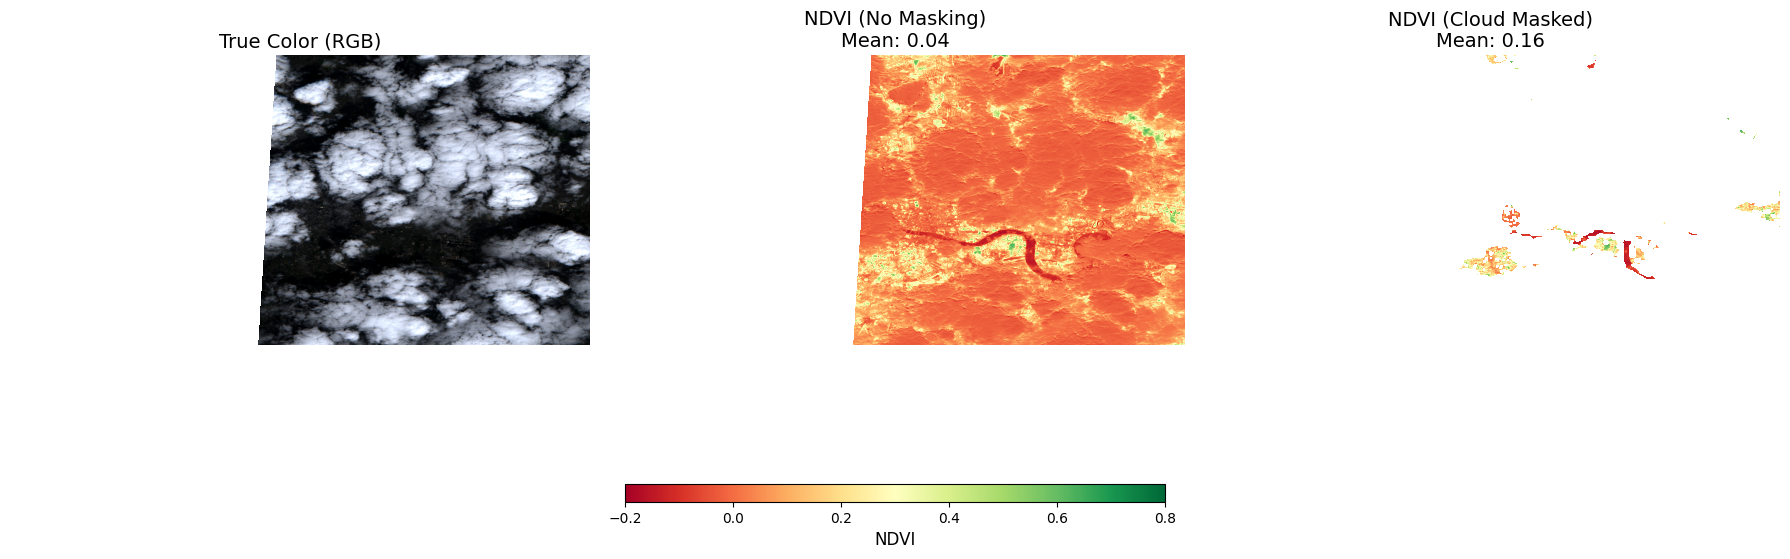

In [225]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# True color
axes[0].imshow(rgb)
axes[0].set_title("True Color (RGB)", fontsize=14)
axes[0].axis("off")

# NDVI without masking
im1 = axes[1].imshow(ndvi_raw, cmap='RdYlGn', vmin=-0.2, vmax=0.8)
axes[1].set_title(f"NDVI (No Masking)\nMean: {np.nanmean(ndvi_raw):.2f}", fontsize=14)
axes[1].axis("off")

# NDVI with masking (NaN pixels will appear white/transparent)
im2 = axes[2].imshow(ndvi_masked, cmap='RdYlGn', vmin=-0.2, vmax=0.8)
axes[2].set_title(f"NDVI (Cloud Masked)\nMean: {np.nanmean(ndvi_masked):.2f}", fontsize=14)
axes[2].axis("off")

plt.tight_layout()

# Add colorbar at the bottom
cbar_ax = fig.add_axes([0.35, 0.06, 0.3, 0.03])
cbar = fig.colorbar(im2, cax=cbar_ax, orientation='horizontal')
cbar.set_label('NDVI', fontsize=12)
plt.subplots_adjust(bottom=0.15)

plt.show()

### Interpreting the Results

**Left (True Color):** Shows where clouds are located

**Middle (No Masking):** Clouds show as yellow/orange (low NDVI) — this is WRONG!

**Right (Cloud Masked):** 
- Cloudy pixels are now white (NaN) — we acknowledge we don't know the ground value
- The mean NDVI is now higher (and more accurate!) because we're not averaging in fake low values from clouds
- We only report NDVI for pixels where we actually see the ground

---
## 11. Compare with a Clear Day

Let's load a clear image from the same location to see what the "true" NDVI should be.

In [226]:
# Search for a clear image (same location, low cloud cover)
search_clear = catalog.search(
    collections=["sentinel-2-l2a"],
    bbox=bbox,
    datetime="2024-01-01/2024-12-31",
    query={"eo:cloud_cover": {"lt": 10}},  # Less than 5% clouds
)

clear_items = list(search_clear.items())
print(f"Found {len(clear_items)} clear images")

# Pick one close in time to our cloudy image (for fair comparison)
cloudy_date = cloudy_item.datetime
clear_items_sorted = sorted(clear_items, key=lambda x: abs((x.datetime - cloudy_date).days))
clear_item = clear_items_sorted[0]

print(f"\nCloudy image: {cloudy_item.datetime.strftime('%Y-%m-%d')} ({cloudy_item.properties.get('eo:cloud_cover', 0):.1f}% clouds)")
print(f"Clear image:  {clear_item.datetime.strftime('%Y-%m-%d')} ({clear_item.properties.get('eo:cloud_cover', 0):.1f}% clouds)")

Found 20 clear images

Cloudy image: 2024-06-24 (35.6% clouds)
Clear image:  2024-06-26 (3.8% clouds)


In [227]:
# Load the clear image
signed_clear = pc.sign(clear_item)
clear_data = stac_load(
    [signed_clear],
    bands=["B02", "B03", "B04", "B08", "SCL"],
    bbox=bbox,
    crs="EPSG:4326",
    resolution=0.0001,
    groupby="solar_day",
)

# Compute RGB and NDVI for clear image
clear_rgb = normalize(np.stack([
    clear_data["B04"].isel(time=0).values,
    clear_data["B03"].isel(time=0).values,
    clear_data["B02"].isel(time=0).values,
], axis=-1))

clear_nir = clear_data["B08"].isel(time=0).values.astype("float32")
clear_red = clear_data["B04"].isel(time=0).values.astype("float32")
clear_ndvi = compute_ndvi(clear_nir, clear_red)

print(f"Clear image NDVI mean: {np.nanmean(clear_ndvi):.2f}")

Clear image NDVI mean: 0.25


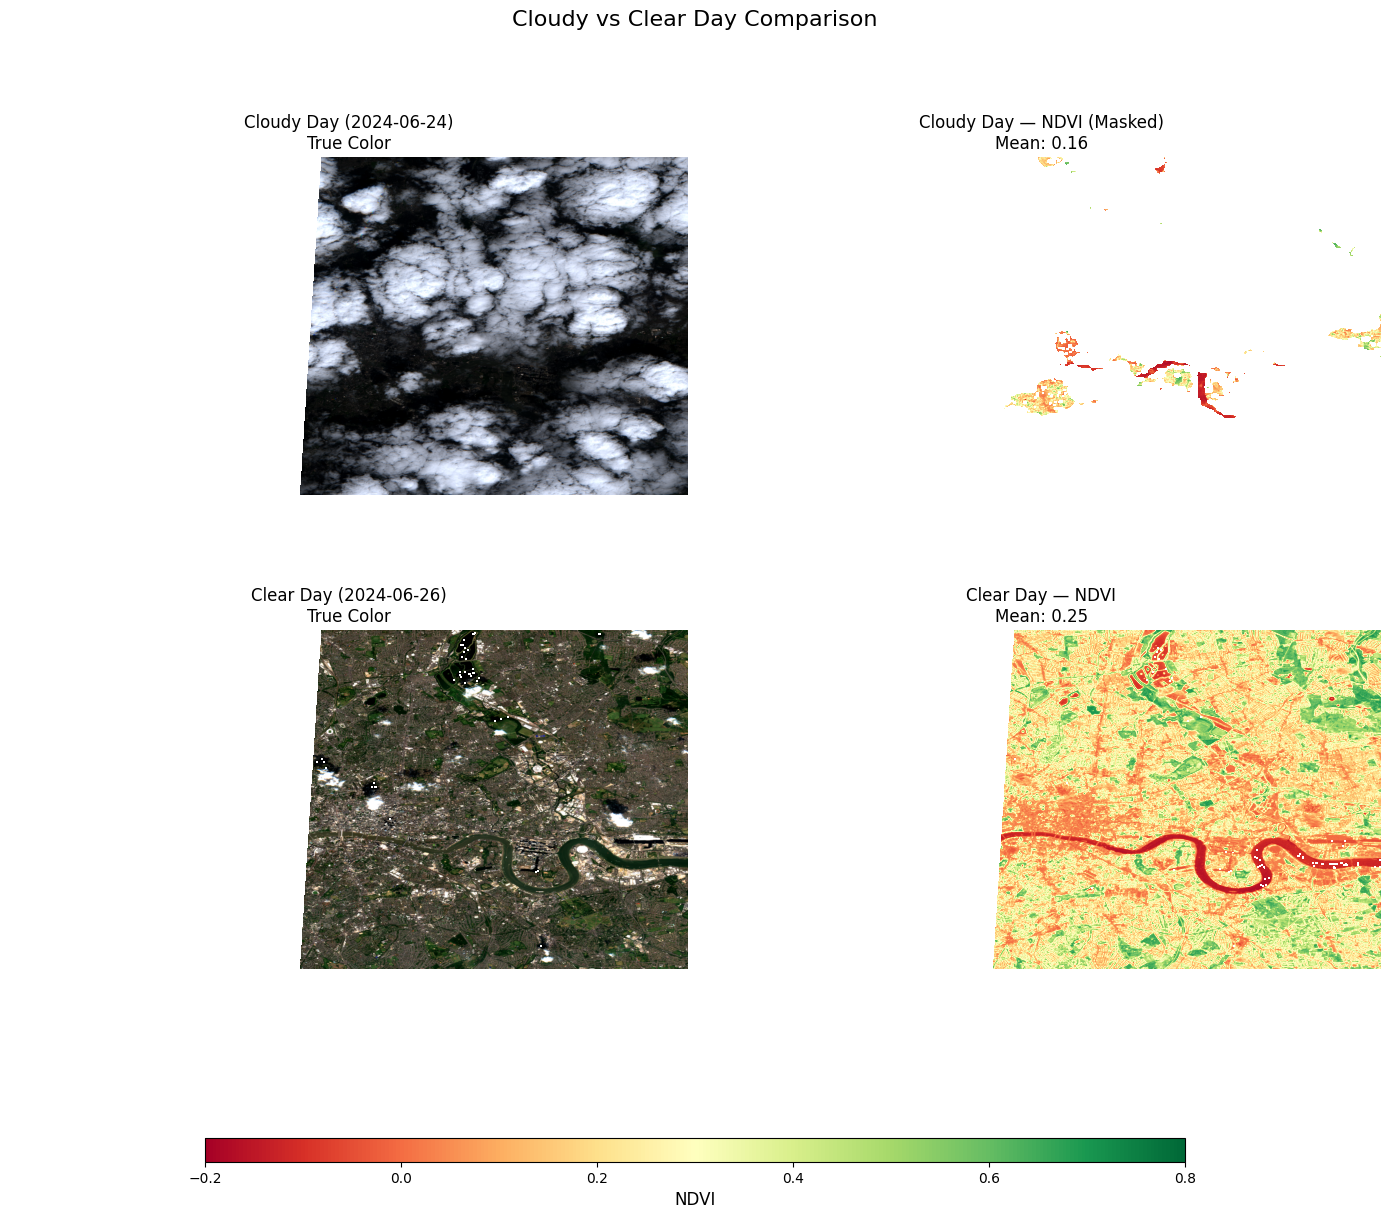

In [228]:
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# Cloudy - True Color
axes[0, 0].imshow(rgb)
axes[0, 0].set_title(f"Cloudy Day ({cloudy_item.datetime.strftime('%Y-%m-%d')})\nTrue Color", fontsize=12)
axes[0, 0].axis("off")

# Cloudy - NDVI Masked
im1 = axes[0, 1].imshow(ndvi_masked, cmap='RdYlGn', vmin=-0.2, vmax=0.8)
axes[0, 1].set_title(f"Cloudy Day — NDVI (Masked)\nMean: {np.nanmean(ndvi_masked):.2f}", fontsize=12)
axes[0, 1].axis("off")

# Clear - True Color
axes[1, 0].imshow(clear_rgb)
axes[1, 0].set_title(f"Clear Day ({clear_item.datetime.strftime('%Y-%m-%d')})\nTrue Color", fontsize=12)
axes[1, 0].axis("off")

# Clear - NDVI
im2 = axes[1, 1].imshow(clear_ndvi, cmap='RdYlGn', vmin=-0.2, vmax=0.8)
axes[1, 1].set_title(f"Clear Day — NDVI\nMean: {np.nanmean(clear_ndvi):.2f}", fontsize=12)
axes[1, 1].axis("off")

plt.suptitle("Cloudy vs Clear Day Comparison", fontsize=16)
plt.tight_layout()

# Add colorbar
cbar_ax = fig.add_axes([0.15, 0.02, 0.7, 0.02])
cbar = fig.colorbar(im2, cax=cbar_ax, orientation='horizontal')
cbar.set_label('NDVI', fontsize=12)
plt.subplots_adjust(bottom=0.08)

plt.show()

---
## 12. Create a Reusable Cloud Masking Function

Let's wrap this into a function we can use in future notebooks.

In [229]:
def create_cloud_mask(scl_band, valid_classes=[4, 5, 6]):
    """
    Create a cloud mask from Sentinel-2 SCL band.
    
    Parameters:
    -----------
    scl_band : numpy array
        The Scene Classification Layer band
    valid_classes : list
        SCL values to consider valid (default: vegetation, bare soil, water)
        
    Returns:
    --------
    mask : numpy array (boolean)
        True = valid pixel, False = cloud/shadow/invalid
    """
    return np.isin(scl_band, valid_classes)


def compute_masked_ndvi(nir, red, scl, valid_classes=[4, 5, 6]):
    """
    Compute NDVI with cloud masking.
    
    Parameters:
    -----------
    nir : numpy array
        Near-infrared band (B08)
    red : numpy array
        Red band (B04)
    scl : numpy array
        Scene Classification Layer band
    valid_classes : list
        SCL values to consider valid
        
    Returns:
    --------
    ndvi : numpy array
        NDVI with invalid pixels set to NaN
    """
    ndvi = compute_ndvi(nir.astype('float32'), red.astype('float32'))
    mask = create_cloud_mask(scl, valid_classes)
    ndvi[~mask] = np.nan
    return ndvi


# Test it
test_ndvi = compute_masked_ndvi(
    data["B08"].isel(time=0).values,
    data["B04"].isel(time=0).values,
    data["SCL"].isel(time=0).values
)
print(f"Test - Masked NDVI mean: {np.nanmean(test_ndvi):.2f}")
print("Functions ready for use in future notebooks!")

Test - Masked NDVI mean: 0.16
Functions ready for use in future notebooks!


---
## Summary

**The Problem:**
- Clouds block sunlight from reaching the ground
- Satellites measure cloud reflectance instead of surface reflectance
- This corrupts NDVI values (clouds → NDVI ≈ 0, regardless of what's underneath)

**The Solution:**
- Sentinel-2 provides a Scene Classification Layer (SCL) that identifies each pixel's type
- We use SCL to create a mask: keep vegetation/soil/water, exclude clouds/shadows
- Apply mask before analysis: invalid pixels → NaN

**Key SCL Values:**
| Code | Class | Use in NDVI? |
|------|-------|-------------|
| 4 | Vegetation | Yes |
| 5 | Bare Soil | Yes |
| 6 | Water | Yes (will be negative) |
| 3 | Cloud Shadow | No |
| 8 | Cloud (Medium) | No |
| 9 | Cloud (High) | No |
| 10 | Thin Cirrus | No |

**Impact:**
- Masked NDVI is more accurate (not biased low by clouds)
- We acknowledge uncertainty by setting unknown pixels to NaN
- Time series analysis becomes more reliable

**Next steps:**
- Apply cloud masking to our time series notebook
- Explore cloud compositing (combining multiple images to fill gaps)
- Use QA bands for more sophisticated filtering